# **\[SOLAR_A\]** GConvLSTM (시뮬레이션)

JiyunLim  
2023-08-17

In [8]:
# modules 
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
#import seaborn as sns
import torch
#import eptstgcn
import torch_geometric_temporal
from torch_geometric_temporal.signal.static_graph_temporal_signal import StaticGraphTemporalSignal
#import mplcyberpunk

# torch
import torch
import torch.nn.functional as F
#import torch_geometric_temporal
# from torch_geometric_temporal.nn.recurrent import GConvGRU
from torch_geometric_temporal.nn.recurrent import GConvLSTM
# from torch_geometric_temporal.nn.recurrent import GCLSTM
# from torch_geometric_temporal.nn.recurrent import LRGCN
# from torch_geometric_temporal.nn.recurrent import TGCN
# from torch_geometric_temporal.nn.recurrent import DCRNN

# read data
def makedict(FX,W=None,node_ids=None):
    T,N = np.array(FX).shape
    if W==None:
        W = pd.DataFrame(FX).corr().to_numpy().reshape(-1).tolist() # corr 로 weights
    if node_ids==None:
        node_ids = ['node'+str(n) for n in range(N)]
    _dict={
        'edges':[[i,j] for i in range(N) for j in range(N)], 
        'node_ids': node_ids,
        'weights':W,
        'FX':FX
    }
    return _dict

class Loader(object):
    def __init__(self, data_dict):
        self._dataset = data_dict
    
    def _get_edges(self):
        self._edges = np.array(self._dataset["edges"]).T

    def _get_edge_weights(self):
        # self._edge_weights = np.array(self._dataset["weights"]).T
        edge_weights = np.array(self._dataset["weights"]).T
        #scaled_edge_weights = minmaxscaler(edge_weights)
        self._edge_weights = edge_weights

    def _get_targets_and_features(self):
        stacked_target = np.stack(self._dataset["FX"])
        self.features = np.stack([
            stacked_target[i : i + self.lags, :].T
            for i in range(stacked_target.shape[0] - self.lags)
        ])
        self.targets = np.stack([
            stacked_target[i + self.lags, :].T
            for i in range(stacked_target.shape[0] - self.lags)
        ])


    def get_dataset(self, lags: int = 4) -> StaticGraphTemporalSignal:
        self.lags = lags
        self._get_edges()
        self._get_edge_weights()
        self._get_targets_and_features()
        dataset = StaticGraphTemporalSignal(
            self._edges, self._edge_weights, self.features, self.targets
        )
        dataset.node_ids = self._dataset['node_ids']
        return dataset
    

# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

class RGCN_Learner:
    def __init__(self):
        self.method = 'RecurrentGCN'
        self.figs = []
        self.epochs = 0
        self.losses = []
        self._node_idx = 0
    def load(self,y): 
        if (self.lags is None) or (self.train_ratio is None):
            self.lags = 2 
            self.train_ratio = 0.8 
        self.t,self.n = y.shape
        dct = makedict(FX=y.tolist())
        self.loader = Loader(dct)
        self.dataset = self.loader.get_dataset(lags=self.lags)
        self.X = torch.tensor(self.dataset.features).float()
        self.y = torch.tensor(self.dataset.targets).float()
        self.train_dataset, self.test_dataset = torch_geometric_temporal.signal.temporal_signal_split(self.dataset, train_ratio = self.train_ratio)
        self.len_test = self.test_dataset.snapshot_count
        self.len_tr = self.train_dataset.snapshot_count
        #self.dataset_name = str(self.train_dataset) if dataset_name is None else dataset_name
        # self.train_dataset_batch = torch.utils.data.DataLoader(self.train_dataset,batch_size=256)
    def get_batches(self, batch_size=256):
        num_batches =  self.len_tr // batch_size + (1 if self.len_tr % batch_size != 0 else 0)
        self.batches = []
        for i in range(num_batches):
            start_idx = i * batch_size
            end_idx = start_idx + batch_size
            self.batches.append(self.train_dataset[start_idx:end_idx])
    
    def learn(self,epoch=1):
        self.model.train()
        for e in range(epoch):
            losses_batch = []
            for b,batch in enumerate(self.batches):
                loss = 0
                self.h, self.c = None, None
                for t, snapshot in enumerate(batch):
                    snapshot = snapshot.to(device)
                    yt_hat, self.h, self.c = self.model(snapshot.x, snapshot.edge_index, snapshot.edge_attr, self.h, self.c)
                    # yt_hat = self.model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
                    loss = loss + torch.mean((yt_hat.reshape(-1)-snapshot.y.reshape(-1))**2)
                    print(f'\rbatch={b}\t t={t+1}\t loss={loss/(t+1)}\t', end='', flush=True)
                loss = loss / (t+1)
                loss.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()
                losses_batch.append(loss.item())
            self.epochs = self.epochs + 1
            print(f'\repoch={self.epochs}\t loss={np.mean(losses_batch)}\n', end='', flush=True)
        self.losses.append(np.mean(losses_batch))
        self._savefigs() 
    def _savefigs(self): 
        self.__call__()
        self._node_idx
        with plt.style.context('default'): 
            plt.ioff()
            plt.rcParams['figure.figsize'] = [20, 3]  # [가로 크기, 세로 크기]
            fig,ax = plt.subplots()
            ax.plot(self.y[:,self._node_idx],label='real',lw=0.5)
            ax.plot(self.yhat[:,self._node_idx],'--',label='predited',alpha=0.5)
            ax.set_title(f'Epoch={self.epochs}, node_idx={self._node_idx}',size=15)
            ax.legend()
            #mplcyberpunk.add_glow_effects()  
        self.figs.append(fig)
        plt.close()
    def __call__(self,dataset=None):
        if dataset == None: 
            dataset = self.dataset
        self.yhat = torch.stack([self.model(snapshot.x, snapshot.edge_index, snapshot.edge_attr, self.h, self.c)[0] for snapshot in dataset]).detach().squeeze().float()
        return {'X':self.X, 'y':self.y, 'yhat':self.yhat} 
    

def rslt_plot(y, yhat, t_, node_idx):
    with plt.style.context('default'): 
            plt.ioff()
            plt.rcParams['figure.figsize'] = [20, 3]  # [가로 크기, 세로 크기]
            fig,ax = plt.subplots()
            ax.plot(y[:t_,node_idx],label='real',lw=0.5)
            ax.plot(yhat[:t_,node_idx],'--',label='predited',alpha=0.5)
            ax.set_title(f'Epoch={lrnr.epochs}, node_idx={node_idx}',size=15)
            ax.legend()

In [9]:
class GConv_LSTM(torch.nn.Module):
    def __init__(self, node_features, filters):
        super(GConv_LSTM, self).__init__()
        self.recurrent = GConvLSTM(in_channels = node_features, out_channels = filters, K = 2)
        self.linear = torch.nn.Linear(filters, 1)

    def forward(self, x, edge_index, edge_weight, h, c):
        h_0, c_0 = self.recurrent(x, edge_index, edge_weight, h, c)
        h = F.relu(h_0)
        h = self.linear(h)
        return h, h_0, c_0

## Load data

In [10]:
# read dataframe 
df = pd.read_csv('data_eng_230710.csv')

# make y, y_upper, y_period, time, regions 
y = df.loc[:,'Bukchoncheon':'Gyeongju-si'].to_numpy()
yU = df.loc[:,'Bukchoncheon_Upper':'Gyeongju-si_Upper'].to_numpy()
yP = np.divide(y, yU+1e-10)

t = df.loc[:,'date']
regions = list(df.loc[:, 'Bukchoncheon':'Gyeongju-si'].columns)

In [11]:
# global parameters
TRAIN_RATIO = 0.8
T, N = len(t), len(regions)
LEN_TEST = int(np.floor(T*(1-TRAIN_RATIO)))
LEN_TR = T - LEN_TEST

## sample codes

`-` y를 학습

In [81]:
# step1: create lrnr object
lrnr = RGCN_Learner()
# step2: load data 
lrnr.lags = 24
lrnr.train_ratio = 0.8
lrnr.load(y) 
# step3: construct networks 
lrnr.nof_filters = 16
lrnr.model = GConv_LSTM(node_features=lrnr.lags, filters=lrnr.nof_filters).to(device)
lrnr.optimizer = torch.optim.Adam(lrnr.model.parameters(),lr=10/1000)
# step4: learn 
lrnr.get_batches(batch_size=128)
for e in range(10):    
    lrnr.learn()

epoch=1  loss=0.678111826069653062221527        
epoch=2  loss=0.2245732629671692861222076   
epoch=3  loss=0.1521157529205083829668427   
epoch=4  loss=0.1189907127991318788727951   
epoch=5  loss=0.1065451535396277953658295   
epoch=6  loss=0.0995985628105757426929474       
epoch=7  loss=0.0932268141768872747138596       
epoch=8  loss=0.089865282177925114208107            
epoch=9  loss=0.0877208467572927513418579   
epoch=10     loss=0.086141652427613746042023        

In [85]:
yhat = np.concatenate([np.array([list(lrnr.yhat[0])]*lrnr.lags),lrnr.yhat],axis=0)
yhat[yhat<0] = 0

In [86]:
((y - yhat)**2).mean()

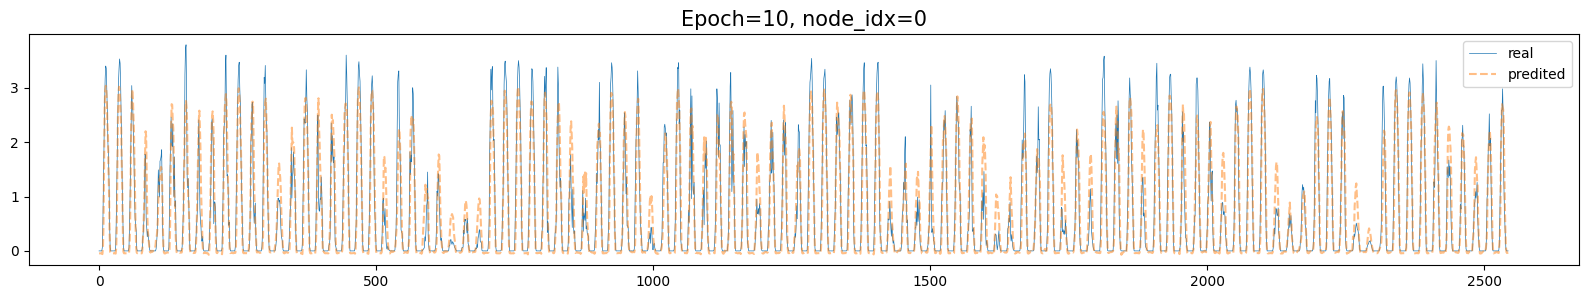

In [87]:
lrnr.figs[-1]

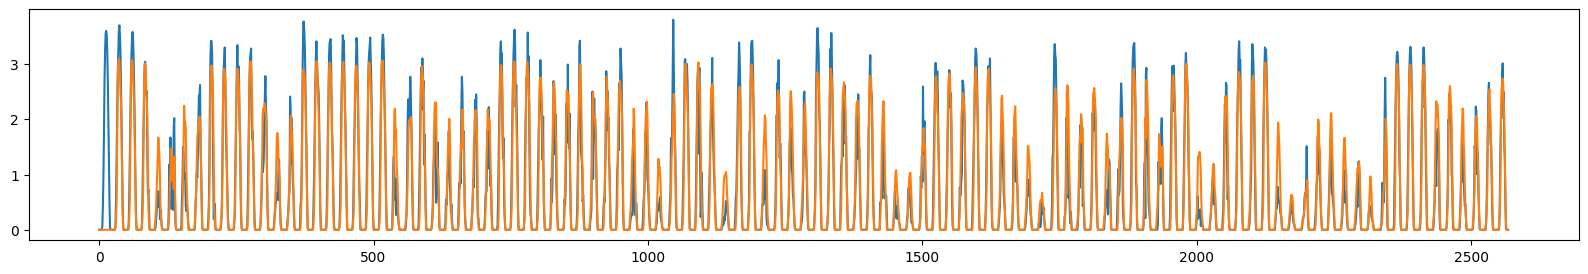

In [88]:
fig,ax = plt.subplots(figsize=(20,3))
ax.plot(y[:,15])
ax.plot(yhat[:,15])
fig

In [89]:
((y-yhat)**2).mean()

In [64]:
#rslt_plot(y, yhat, 100, 1)

`-` yU 학습

In [72]:
# step1: create lrnr object
lrnr = RGCN_Learner()
# step2: load data 
lrnr.lags = 1
lrnr.train_ratio = 0.8
lrnr.load(yU) 
# step3: construct networks 
lrnr.nof_filters = 4
lrnr.model = GConv_LSTM(node_features=lrnr.lags, filters=lrnr.nof_filters).to(device)
lrnr.optimizer = torch.optim.Adam(lrnr.model.parameters(),lr=10/1000)
# step4: learn 
lrnr.get_batches(batch_size=24)
for e in range(5):    
    lrnr.learn()

epoch=1  loss=2.77824564035548746792755     
epoch=2  loss=0.183514381260719421501312        
epoch=3  loss=0.0633472515010211409664154   
epoch=4  loss=0.0362982417803344331887054   
epoch=5  loss=0.0229024141052261336871529   

In [73]:
# yUhat_ = lrnr.yhat
yUhat = np.concatenate([np.array([list(lrnr.yhat[0])]*lrnr.lags),lrnr.yhat],axis=0)

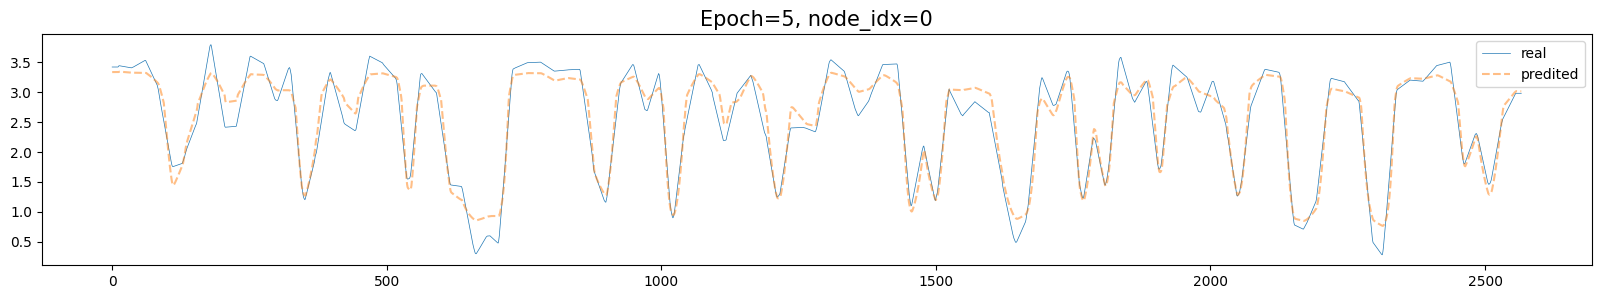

In [74]:
lrnr.figs[-1]

In [68]:
rslt_plot(yU, yUhat, 300, 1)

`-` yP 학습

In [75]:
# step1: create lrnr object
lrnr = RGCN_Learner()
# step2: load data 
lrnr.lags = 24
lrnr.train_ratio = 0.8
lrnr.load(yP) 
# step3: construct networks 
lrnr.nof_filters = 16
lrnr.model = GConv_LSTM(node_features=lrnr.lags, filters=lrnr.nof_filters).to(device)
lrnr.optimizer = torch.optim.Adam(lrnr.model.parameters(),lr=5/1000)
# step4: learn 
lrnr.get_batches(batch_size=128)
for e in range(10):    
    lrnr.learn()

epoch=1  loss=0.0645400105277076464248085       
epoch=2  loss=0.0208255256875418130502739       
epoch=3  loss=0.01845160609809681898477745  
epoch=4  loss=0.0170751797268167146975994       
epoch=5  loss=0.01558796066092327289337254  
epoch=6  loss=0.014246119477320462794137            
epoch=7  loss=0.01328864495735615503538036  
epoch=8  loss=0.01267574771190993581445026  
epoch=9  loss=0.01223041905905125674495697  
epoch=10     loss=0.0118726383952889651140404   

In [78]:
# yPhat_ = lrnr.yhat
yPhat = np.concatenate([np.array([list(lrnr.yhat[0])]*lrnr.lags),lrnr.yhat],axis=0)
yPhat[yPhat<0] = 0

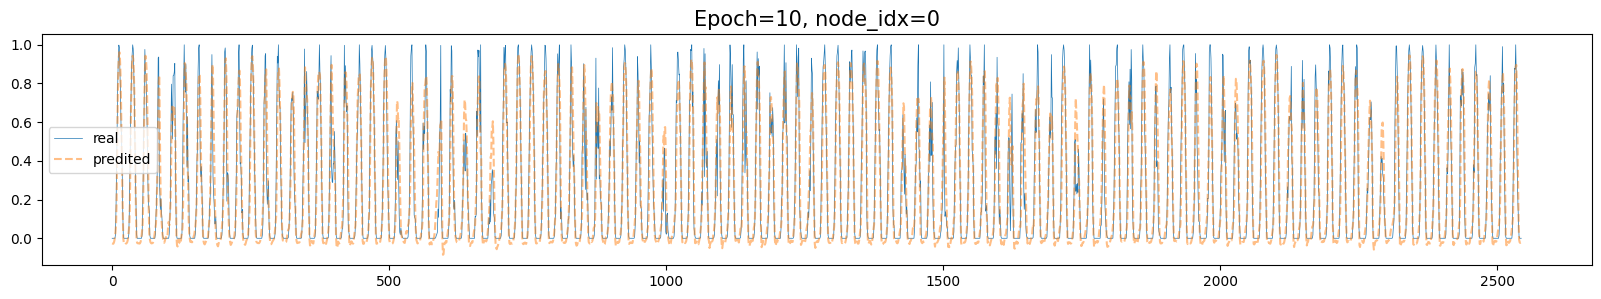

In [79]:
lrnr.figs[-1]

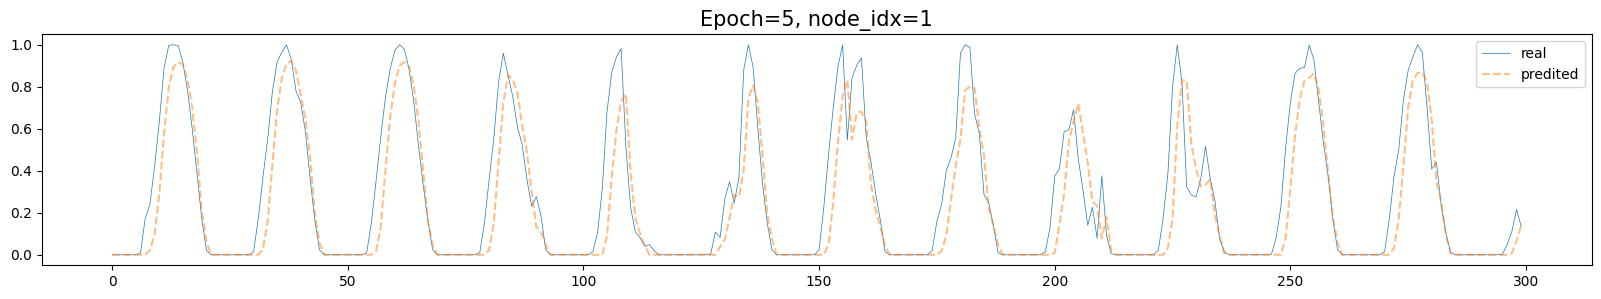

In [45]:
rslt_plot(yP, yPhat, 300, 1)

`-` classic vs. proposed

In [90]:
classic = ((y - yhat)[LEN_TR:,:]**2).mean()
proposed = ((y - yUhat*yPhat)[LEN_TR:,:]**2).mean()
print('classic(mse)', round(classic,4))
print('proposed(mse)', round(proposed,4))

classic(mse) 0.1083
proposed(mse) 0.0735

### Edic rgcn

In [47]:
# learn 
def rgcn(FX, model, train_ratio, lags, filters, epoch):
    # step1: create lrnr object
    lrnr = RGCN_Learner()
    # step2: load data
    lrnr.lags = lags
    lrnr.train_ratio = train_ratio
    lrnr.load(FX)
    # step3: construct networks
    lrnr.nof_filters = filters
    lrnr.model = model(node_features=lrnr.lags, filters=lrnr.nof_filters).to(device)
    lrnr.optimizer = torch.optim.Adam(lrnr.model.parameters(), lr=10/1000)
    # step4: learn
    lrnr.get_batches(batch_size=24)
    for e in range(epoch):
        lrnr.learn()
    yhat = np.concatenate([np.array([list(lrnr.yhat[0])]*lrnr.lags),lrnr.yhat],axis=0)
    return yhat

In [48]:
# hyper params
LAGS = 4
FILTERS = 16
EPOCH = 5

`-` classic

In [50]:
yhat = rgcn(y, GConv_LSTM, train_ratio = TRAIN_RATIO, lags=LAGS, filters = FILTERS, epoch=EPOCH)
yhat[yhat<0] = 0

epoch=1  loss=0.385500249214643653957672        
epoch=2  loss=0.096019307801196750923004            
epoch=3  loss=0.083511633365306742538147    7   
epoch=4  loss=0.081170832435058992692795            
epoch=5  loss=0.080136563563935986343231            

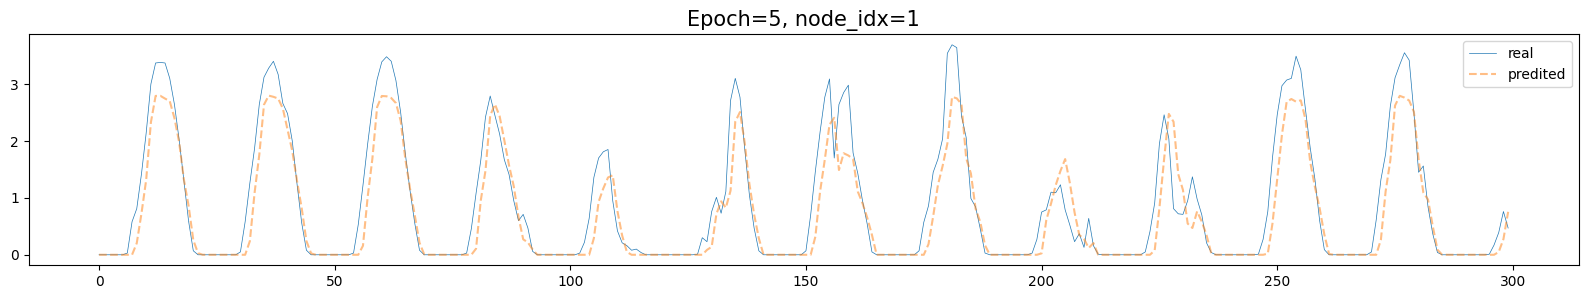

In [52]:
rslt_plot(y, yhat, 300, 1)

In [54]:
np.mean((y-yhat)[LEN_TR:,:]**2)

`-` proposed

In [55]:
# 방법2 
yUhat = rgcn(yU, GConv_LSTM, train_ratio = TRAIN_RATIO, lags=LAGS, filters=FILTERS, epoch=EPOCH)

yPhat = rgcn(yP, GConv_LSTM, train_ratio = TRAIN_RATIO, lags=LAGS, filters=FILTERS, epoch=EPOCH)
yPhat[yPhat < 0] =0 

classic = ((y - yhat)[LEN_TR:, :] ** 2)
proposed = ((y - yUhat*yPhat)[LEN_TR:, :] ** 2)

# print mse
print("""
total_mse(classic): {:.4f}
total_mse(proposed): {:.4f}
""".format(classic.mean(), proposed.mean()))

epoch=1  loss=1.213565460644489352722168    
epoch=2  loss=0.092817681646624281926613        
epoch=3  loss=0.027449196074591127543785            
epoch=4  loss=0.0185868418234032242759476       
epoch=5  loss=0.0118609502056050443508701       
epoch=1  loss=0.0224609425031515042299042       
epoch=2  loss=0.0119824765905261399890938       
epoch=3  loss=0.0112105506678046888116264       
epoch=4  loss=0.0109713261955157794609566       
epoch=5  loss=0.0108544562177104495387764       

total_mse(classic): 0.1451
total_mse(proposed): 0.1394


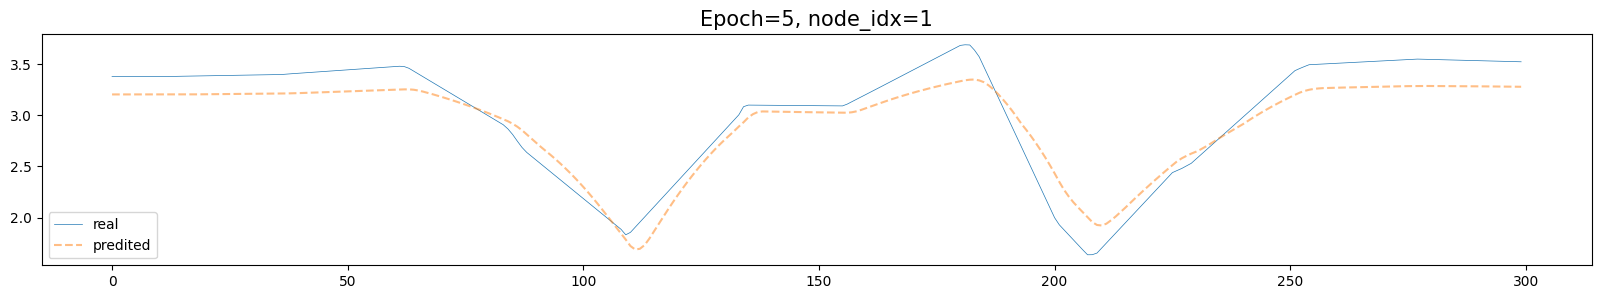

In [56]:
rslt_plot(yU, yUhat, 300, 1)

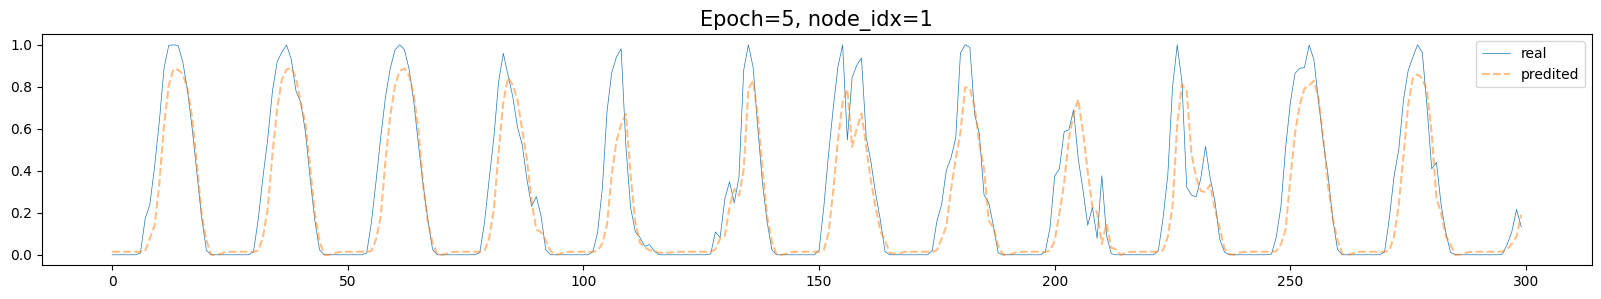

In [57]:
rslt_plot(yP, yPhat, 300, 1)

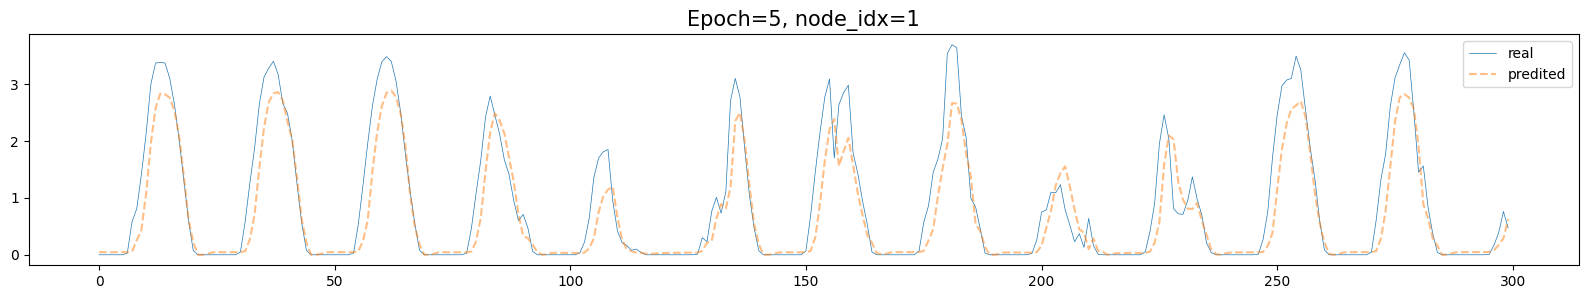

In [58]:
rslt_plot(y, yUhat*yPhat, 300, 1)

## simul code

In [60]:
# for simulation
import itertools
import time
import datetime

class Simulator:
    def __init__(self):
        self.col = ['model', 'method', 'lags', 
       'nof_filters', 'epoch', 'calculation_time',
       'index_time',
       'node', 'mse']
        self.df = pd.DataFrame(columns=self.col)
        self.data = pd.read_csv('data_eng_230710.csv')
    
    def simulate(self,n_iteration,lags,filters,epoch,Model):

        # make y, y_upper, y_period, time, regions 
        y = self.data.loc[:,'Bukchoncheon':'Gyeongju-si'].to_numpy()
        yU = self.data.loc[:,'Bukchoncheon_Upper':'Gyeongju-si_Upper'].to_numpy()
        yP = np.divide(y, yU+1e-10)
        t = self.data.loc[:,'date']
        regions = list(self.data.loc[:,'Bukchoncheon':'Gyeongju-si'].columns)
        
        TRAIN_RATIO = 0.8
        T,N = len(t),len(regions) 
        LEN_TEST = int(np.floor(T*(1-TRAIN_RATIO)))
        LEN_TR = T - LEN_TEST        
        
        self.n_iteration = n_iteration
        self.method = ['classic','proposed']
        self.lags = lags
        self.filters = filters
        self.epoch = epoch
        self.Model = Model
        model_name= Model.__name__.replace('_','')

        for iteration in range(n_iteration):
            for m,l,f,e in itertools.product(self.method, self.lags, self.filters, self.epoch):
                if m == 'classic':
                    t1 = time.time()
                    # model = self.Model(node_features=l, filters=f) 
                    # yhat = rgcn(y, model = model, train_ratio = TRAIN_RATIO, lags=l, epoch=e)
                    yhat = rgcn(y, Model, train_ratio = TRAIN_RATIO, lags=LAGS, filters=FILTERS, epoch=EPOCH)
                    yhat[yhat < 0]= 0   
                    t2 = time.time()
                    c = t2-t1
                    t = str(datetime.datetime.now())
                    _df2 = pd.concat([pd.Series(regions),pd.Series(((y - yhat)[LEN_TR:, :] ** 2).mean(axis=0))],axis=1)
                    _df1 = pd.DataFrame([[model_name,m,l,f,e,c,t]]*N)
                    _df = pd.concat([_df1,_df2],axis=1).set_axis(self.col,axis=1)
                    self.df = pd.concat([self.df,_df])
                else: # proposed 
                    t1 = time.time()
                    # model = self.Model(node_features=l, filters=f)
                    # yUhat = rgcn(yU, model = model, train_ratio = 0.8, lags=l, epoch=e)
                    yUhat = rgcn(yU, Model, train_ratio = TRAIN_RATIO, lags=LAGS, filters=FILTERS, epoch=EPOCH)
                    # model = self.Model(node_features=l, filters=f)
                    # yPhat = rgcn(yP, model = model, train_ratio = TRAIN_RATIO, lags=l, epoch=e)
                    yPhat = rgcn(yP, Model, train_ratio = TRAIN_RATIO, lags=LAGS, filters=FILTERS, epoch=EPOCH)
                    yPhat[yPhat < 0] =0 
                    yhat = yUhat*yPhat
                    t2 = time.time()
                    c = t2-t1
                    t = str(datetime.datetime.now())
                    _df2 = pd.concat([pd.Series(regions),pd.Series(((y - yhat)[LEN_TR:, :] ** 2).mean(axis=0))],axis=1)
                    _df1 = pd.DataFrame([[model_name,m,l,f,e,c,t]]*N)
                    _df = pd.concat([_df1,_df2],axis=1).set_axis(self.col,axis=1)
                    self.df = pd.concat([self.df,_df])
                print("method:{} lag:{} filters:{} epoch:{} is done".format(m,l,f,e))        
            # self.df = self.df.groupby('index_time').agg({'mse':np.mean}).reset_index().rename({'mse':'mse_mean'},axis=1).merge(self.df)
            self.df.to_csv("./results/test/SOLAR_{}.csv".format(str(pd.to_datetime(datetime.datetime.now())) + str('_') + model_name.lower()),index=False)
            print("save results")

`-` test1

In [99]:
s1 = Simulator()

In [ ]:
s1.simulate(
    n_iteration = 1,
    lags = [2, 4, 8, 12, 24],
    filters = [4, 8, 16, 32],
    epoch = [100],
    Model = GConv_LSTM
)

epoch=4  loss=0.080567870873871245112381            
batch=14     t=24    loss=0.09854843467473984           method:classic lag:2 filters:32 epoch:100 is done
epoch=1  loss=0.530105488937954639074707            
epoch=3  loss=0.086034318475529214736252            
batch=22     t=9     loss=0.1418917030096054                    method:classic lag:8 filters:4 epoch:100 is done
epoch=1  loss=0.39729237331207407324936             
epoch=5  loss=0.082247338452657987898483            
method:classic lag:8 filters:32 epoch:100 is done
epoch=4  loss=0.083875248966695265390625            
epoch=5  loss=0.08181716094529906879036             
method:classic lag:24 filters:16 epoch:100 is done
epoch=4  loss=0.0110650959595236562392235       
epoch=4  loss=0.0233299789820299627360344       
epoch=5  loss=0.0155936330286136231642532       
epoch=4  loss=0.011008180366547476640955            
epoch=5  loss=0.0107898814062219728684692       
method:proposed lag:4 filters:8 epoch:100 is done
epoch=5  l

In [101]:
import os
fnames = ['./results/test/'+l for l in os.listdir('./results/test/') if l[0] != '.']
fnames 

In [102]:
df = pd.concat([pd.read_csv(fname) for fname in fnames]).reset_index(drop=True)
df.head()

In [104]:
df_e1 = df[df['epoch']==5].reset_index()
df_e2 = df[df['epoch']==10].reset_index()
df_e3 = df[df['epoch']==30].reset_index()
df_e4 = df[df['epoch']==50].reset_index()
df_e5 = df[df['epoch']==100].reset_index()

In [115]:
df_e5.groupby(by=['method', 'lags','nof_filters']).agg({'mse':[np.mean]})